In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# from scipy import stats
# from scipy.stats import skew

# from IPython.display import HTML

import matplotlib.pyplot as plt
# import matplotlib.patches as patches
%matplotlib inline

import seaborn as sns

from plotly import tools, subplots
import plotly.offline as py

import plotly.graph_objs as go
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot

py.init_notebook_mode(connected=True)
init_notebook_mode(connected=True)

import os,random, math, psutil, pickle

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import gc

pd.set_option('max_columns', 100)

In [2]:
# set font size for plt plots
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14

<a href='#2'>Let's Start</a>

In [3]:
###########################################################################################################################

In [4]:
path = '../data/raw/'
train = pd.read_csv(path + 'train.csv')
weather_train = pd.read_csv(path + 'weather_train.csv')
test = pd.read_csv(path + 'test.csv')
weather_test = pd.read_csv(path + 'weather_test.csv')
building_meta_df = pd.read_csv(path + 'building_metadata.csv')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

# Features

#### train.csv
- building_id - Foreign key for the building metadata.
- meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, hotwater: 3}. Not every building has all meter types.
- timestamp - When the measurement was taken
- meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

#### building_meta.csv
- site_id - Foreign key for the weather files.
- building_id - Foreign key for training.csv
- primary_use - Indicator of the primary category of activities for the building based on [EnergyStar](https://www.energystar.gov/buildings/facility-owners-and-managers/existing-buildings/use-portfolio-manager/identify-your-property-type) property type definitions
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building

#### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- site_id
- air_temperature - Degrees Celsius
- cloud_coverage - Portion of the sky covered in clouds, in [oktas](https://en.wikipedia.org/wiki/Okta)
- dew_temperature - Degrees Celsius
- precip_depth_1_hr - Millimeters
- sea_level_pressure - Millibar/hectopascals
- wind_direction - Compass direction (0-360)
- wind_speed - Meters per second

#### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

- row_id - Row id for your submission file
- building_id - Building id code
- meter - The meter id code
- timestamp - Timestamps for the test data period

# Merge datasets

In [5]:
# conform to standard datetime format
train["timestamp"] = pd.to_datetime(train["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_train["timestamp"] = pd.to_datetime(weather_train["timestamp"], format='%Y-%m-%d %H:%M:%S')

test["timestamp"] = pd.to_datetime(test["timestamp"], format='%Y-%m-%d %H:%M:%S')
weather_test["timestamp"] = pd.to_datetime(weather_test["timestamp"], format='%Y-%m-%d %H:%M:%S')

In [6]:
# merge datasets
train = train.merge(building_meta_df, how='left', on='building_id')
train = train.merge(weather_train, how='left', on=['site_id', 'timestamp'])

test = test.merge(building_meta_df, how='left', on='building_id')
test = test.merge(weather_test, how='left', on=['site_id', 'timestamp'])

del weather_train, weather_test,building_meta_df
gc.collect()

0

# Reduce memory_usage by changing data types

In [7]:
# Thanks to the competition host. This code is originally from  
# https://www.kaggle.com/caesarlupum/ashrae-start-here-a-gentle-introduction

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
reduce_mem_usage(train)

Memory usage of dataframe is 2622.02 MB
Memory usage after optimization is: 1253.17 MB
Decreased by 52.2%


,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.000000,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.000000,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.000000,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.000000,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.000000,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.700012,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.500000,180.0,8.8
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.500000,180.0,8.8
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.500000,180.0,8.8
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.500000,180.0,8.8


In [9]:
reduce_mem_usage(test)

Memory usage of dataframe is 5408.17 MB
Memory usage after optimization is: 2584.79 MB
Decreased by 52.2%


,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.799999,4.0,11.7,NaN,1021.400024,100.0,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,2018-05-09 07:00:00,15,Entertainment/public assembly,19619,1914.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697596,41697596,1445,0,2018-05-09 07:00:00,15,Education,4298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697597,41697597,1446,0,2018-05-09 07:00:00,15,Entertainment/public assembly,11265,1997.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
41697598,41697598,1447,0,2018-05-09 07:00:00,15,Lodging/residential,29775,2001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data cleaning

It was found that "site 0 were not properly converted to units of kWh and are in kBTU."

To correct the units:
"Multiply by 0.2931 to get to model inputs into kWh like the other sites, and 3.4118 to get back to kBTU for scoring." 

Thanks go to: 
https://www.kaggle.com/c/ashrae-energy-prediction/discussion/118753
https://www.kaggle.com/c/ashrae-energy-prediction/discussion/119261

In [10]:
train.loc[train.site_id==0, 'meter_reading'] = \
train.loc[train.site_id==0, 'meter_reading'].apply(lambda x: x*0.2931)

In [11]:
train.tail()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
20216095,1444,0,2016-12-31 23:00:00,8.750000,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216096,1445,0,2016-12-31 23:00:00,4.825000,15,Education,4298,NaN,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216097,1446,0,2016-12-31 23:00:00,0.000000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216098,1447,0,2016-12-31 23:00:00,159.574997,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8
20216099,1448,0,2016-12-31 23:00:00,2.850000,15,Office,92271,2001.0,NaN,1.7,NaN,-5.6,-1.0,1008.5,180.0,8.8


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int16         
 1   meter               int8          
 2   timestamp           datetime64[ns]
 3   meter_reading       float32       
 4   site_id             int8          
 5   primary_use         category      
 6   square_feet         int32         
 7   year_built          float32       
 8   floor_count         float32       
 9   air_temperature     float32       
 10  cloud_coverage      float32       
 11  dew_temperature     float32       
 12  precip_depth_1_hr   float32       
 13  sea_level_pressure  float32       
 14  wind_direction      float32       
 15  wind_speed          float32       
dtypes: category(1), datetime64[ns](1), float32(10), int16(1), int32(1), int8(2)
memory usage: 1.2 GB


## Save interim data

In [13]:
train.to_pickle('../data/interim/train.pkl')
test.to_pickle('../data/interim/test.pkl')

<a id='2'>Let's Start</a>

#################################################################################################################

# Load dataset

In [14]:
train = pd.read_pickle('../data/interim/train.pkl')
test = pd.read_pickle('../data/interim/test.pkl')
meter_dict = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

# EDA

## Distribution

In [15]:
num_cols = ['building_id', 'meter', 'meter_reading', 'site_id', 'square_feet', 'year_built', 'floor_count', 
            'air_temperature', 'cloud_coverage', 'dew_temperature', 'wind_speed']
# 'precip_depth_1_hr' removed due to error dtype 

In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train['primary_use_encoded'] = le.fit_transform(train['primary_use']).astype(np.int8)
# train['timestamp_encoded'] = le.fit_transform(train['timestamp']).astype(np.int8)

In [17]:
obj_cols = ['primary_use_encoded']
all_cols = num_cols + obj_cols

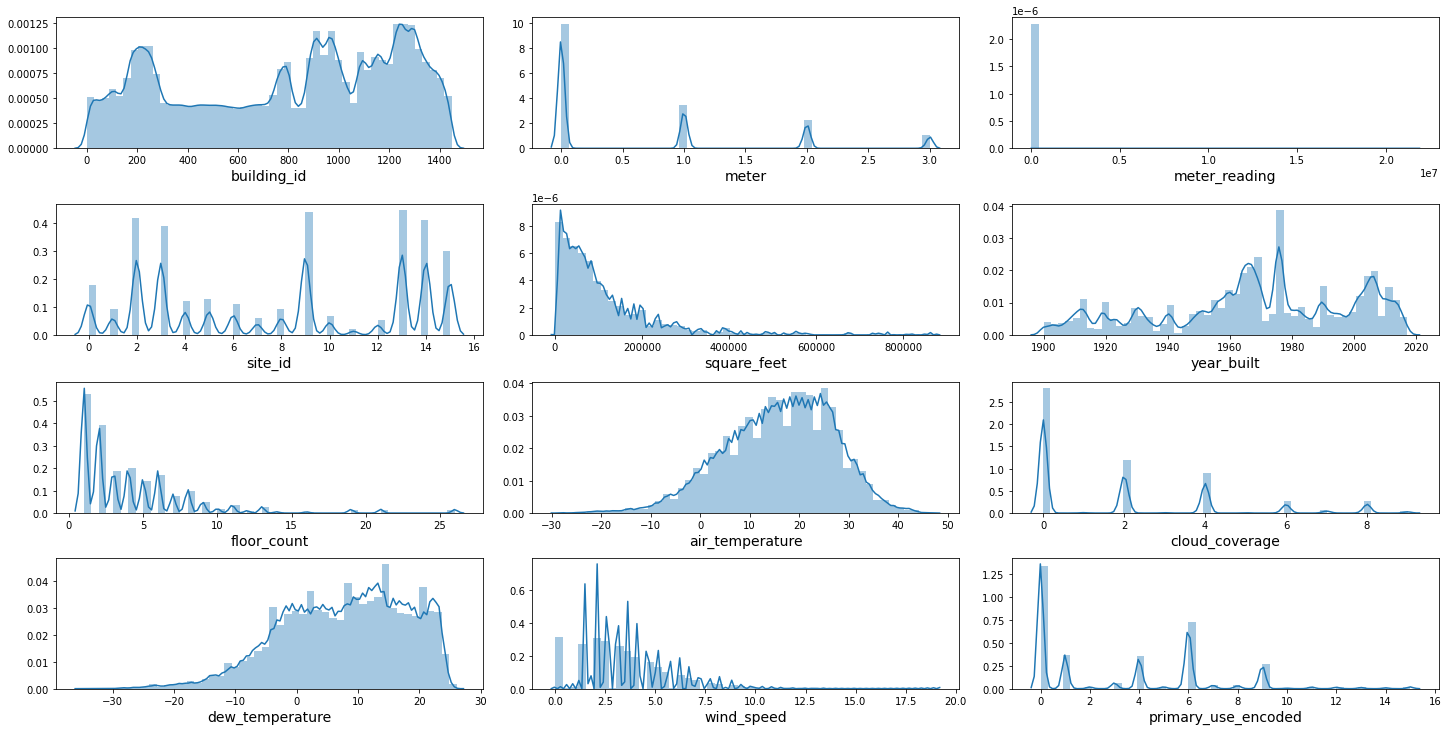

In [18]:
figsize = (20, 12)
cols = 3
rows = len(all_cols) // cols + 1

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, N = len(all_cols))
for axx, col in zip(axs, all_cols):
    # ax.set_title('markevery=%s' % str(case))
    sns.distplot(train[col], ax=axx) 

- Meter reading is severely skewed to larger numbers. Majority of readings are small values.
- There are more electricity type of meters. it is followed by {1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
- Square_feet, floor_count, wind_speed, cloud_coverage are also skewed to larger values.

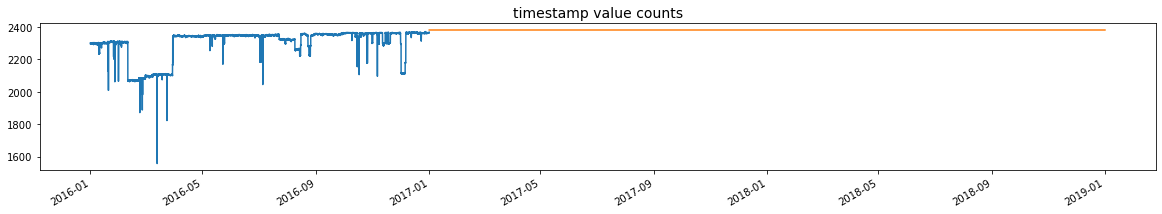

In [19]:
train.timestamp.value_counts().plot(title='timestamp value counts', figsize=(20,3))
test.timestamp.value_counts().plot(figsize=(20,3))

- Blue is for year 2006 as the train set.
- Orange is for year 2017 and 2018. 
- Compared with test set, the training set has missing records in many hours and days.

## Total energy consumption over time

Wall time: 3.56 s


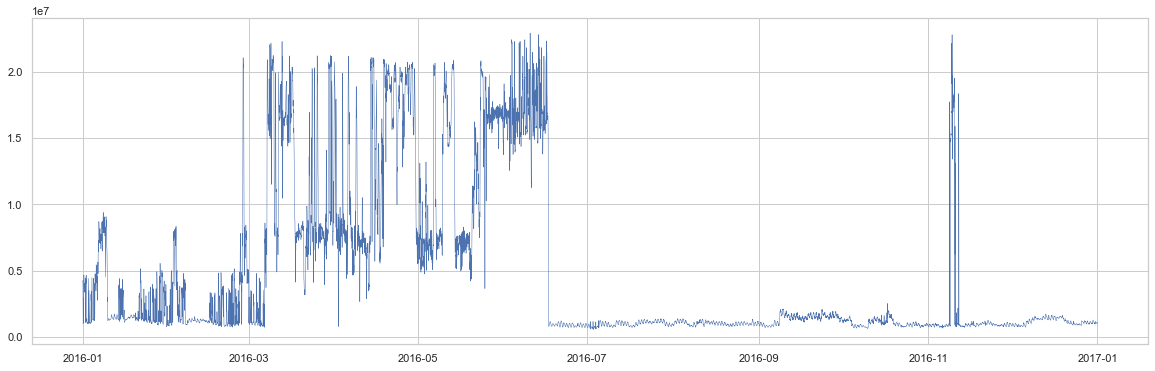

In [20]:
%%time
g = train.groupby(["timestamp"])["meter_reading"].sum()
plt.figure(figsize=(20, 6))
sns.set(style="whitegrid")
sns.lineplot(data=g, linewidth=0.5)

- There is unusually high energy usage from March to June and in a few days in November.

Wall time: 2.69 s


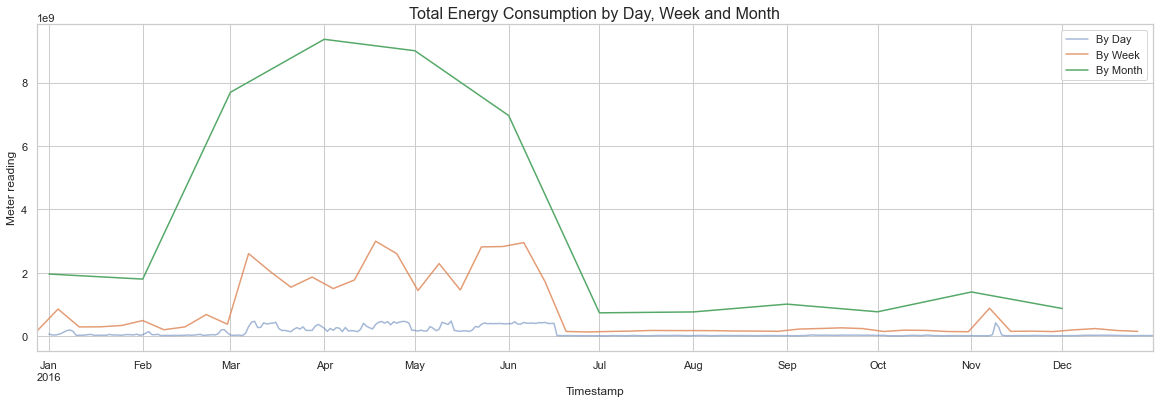

In [21]:
%%time
fig, axes = plt.subplots(1, 1, figsize=(20, 6))
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('D').sum()['meter_reading'].plot(ax=axes, label='By Day', alpha=0.5)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('W').sum()['meter_reading'].plot(ax=axes, label='By Week', alpha=0.8)
train[['timestamp', 'meter_reading']].set_index('timestamp').resample('M').sum()['meter_reading'].plot(ax=axes, label='By Month', alpha=1)
axes.set_title('Total Energy Consumption by Day, Week and Month', fontsize=16)
axes.set_ylabel('Meter reading')
axes.set_xlabel('Timestamp')
axes.legend()

- Look at monthly usage, March through July clearly see more energy consumption. 

## Site specific yearly energy consumption

Wall time: 2 s


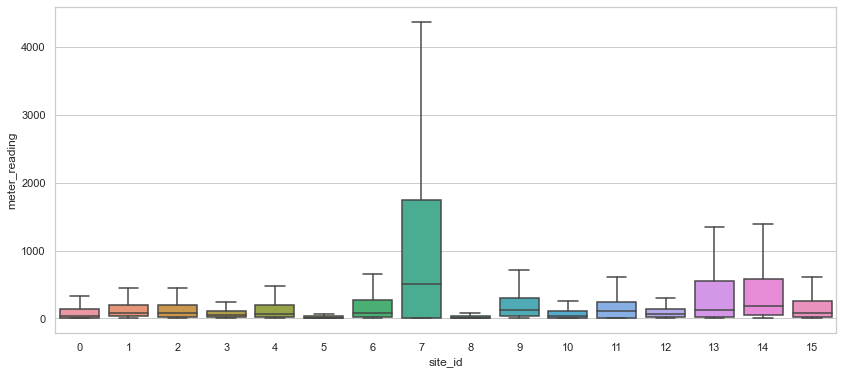

In [22]:
%%time
fig, axes = plt.subplots(1, 1, figsize=(14, 6))
sns.boxplot(x='site_id', y='meter_reading', data=train, showfliers=False)

Wall time: 21.5 s


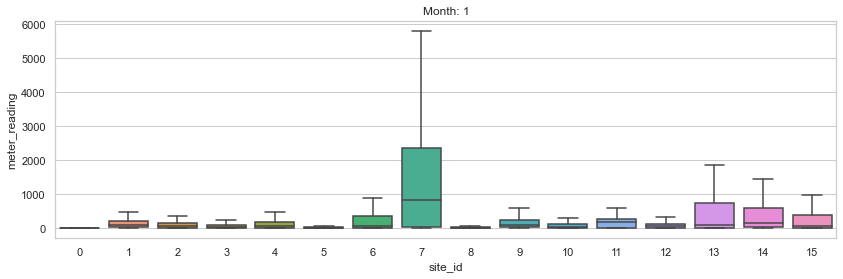

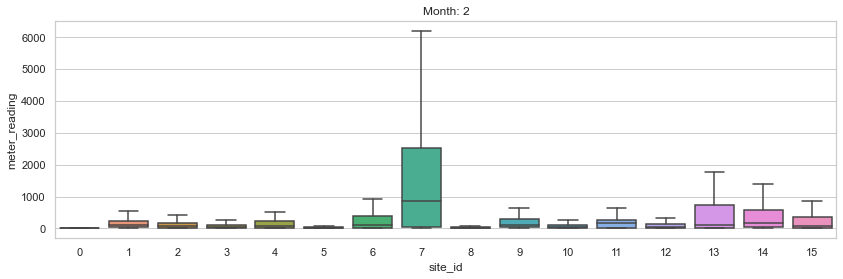

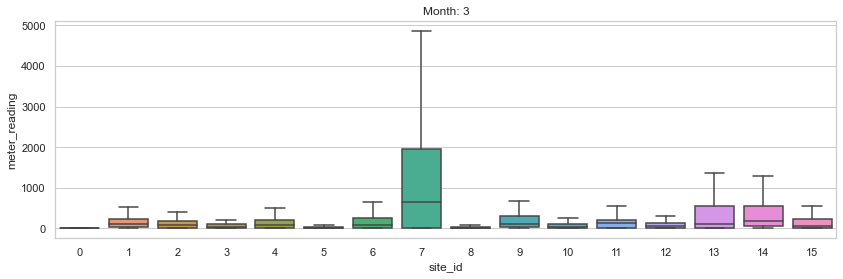

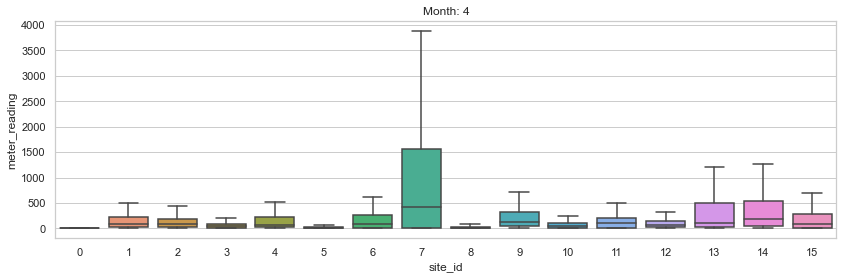

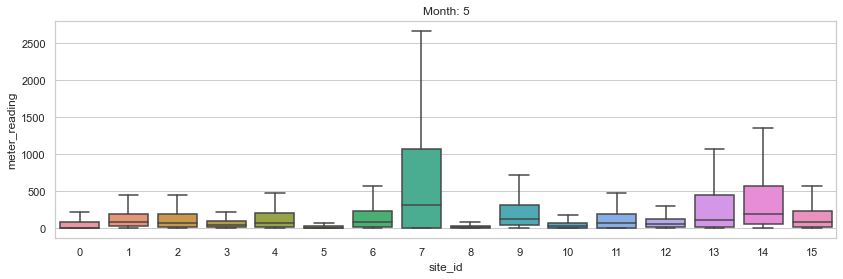

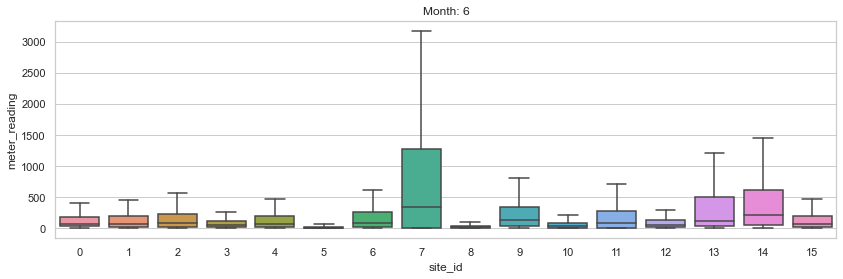

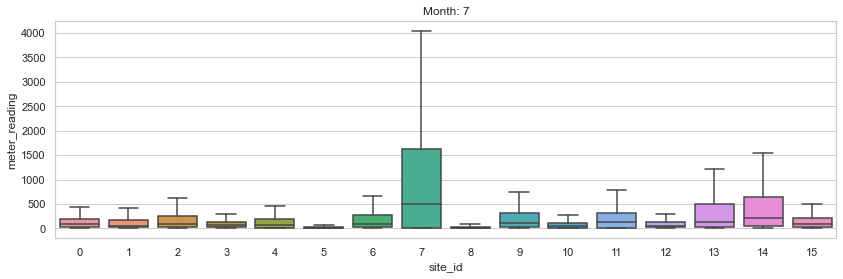

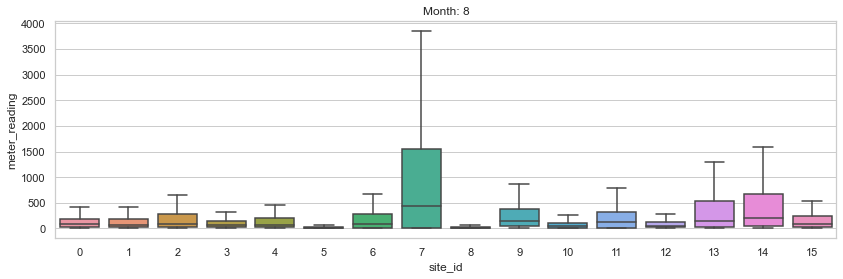

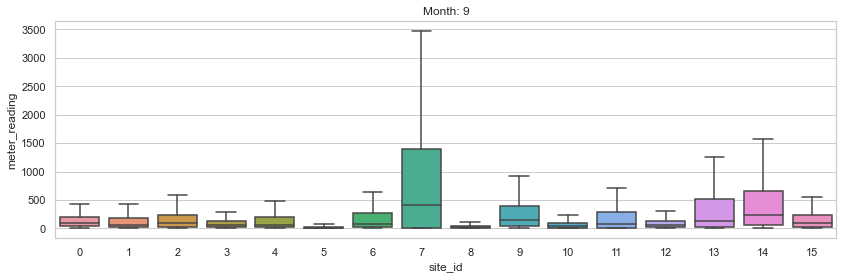

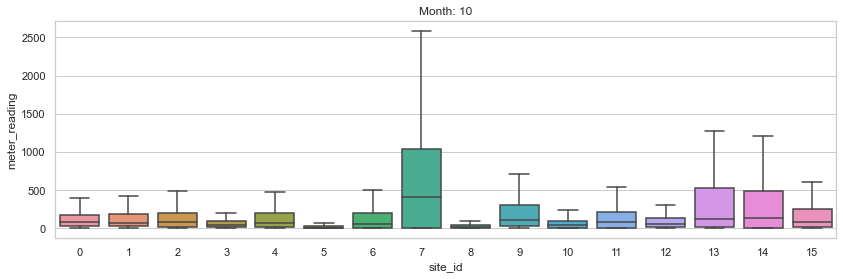

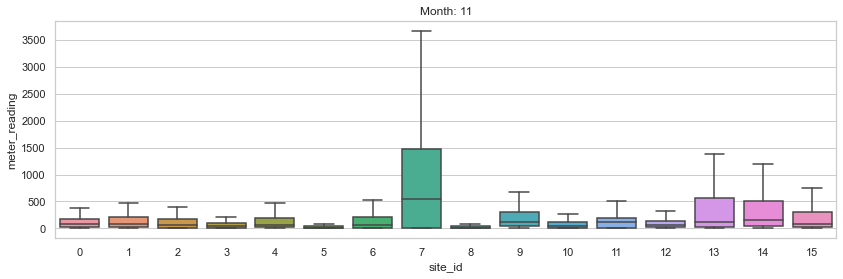

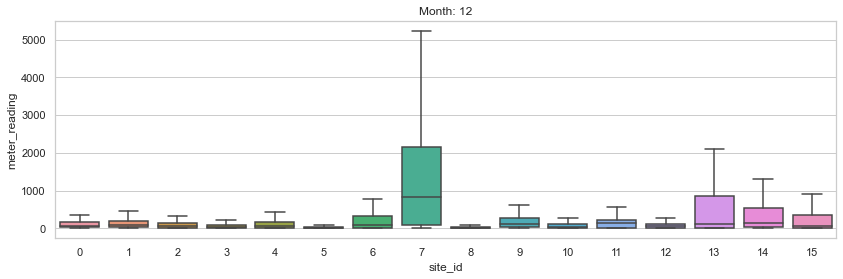

In [23]:
%%time
for i in range(1, 13):
    fig, axes = plt.subplots(1, 1, figsize=(14, 4))
    sns.boxplot(x='site_id', y='meter_reading', data=train[train.timestamp.dt.month==i], showfliers=False)
    plt.title(f'Month: {i}', fontsize=12)

- It is instresting to note that site 7 consumes many times higher energy than other sites thourgh all year. It also has a very large variation.

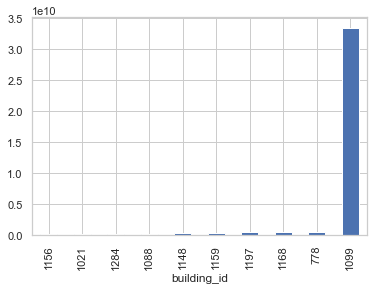

In [24]:
train.groupby('building_id')['meter_reading'].sum().sort_values()[-10:].plot(kind='bar')

In [25]:
train.groupby('building_id')['meter_reading'].sum().sort_values()[-10:]

building_id
1156    1.284771e+08
1021    1.416654e+08
1284    1.926674e+08
1088    2.082382e+08
1148    2.638549e+08
1159    3.142415e+08
1197    3.904003e+08
1168    4.286342e+08
778     4.404115e+08
1099    3.350620e+10
Name: meter_reading, dtype: float32

- It is found that building 1099 eats up too much energy. It isate least about 100 times higher that other buidlings.

In [26]:
train[train.building_id==1099][['primary_use', 'site_id']].iloc[-1, :]

primary_use    Education
site_id               13
Name: 20215321, dtype: object

- The building 1099 belongs to site 13 and is an Educational institution.

In [27]:
list(train)

['building_id',
 'meter',
 'timestamp',
 'meter_reading',
 'site_id',
 'primary_use',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'primary_use_encoded']

## Meter type

In [28]:
def groupby_pxline(df, x, c, y):
    # c column will be used for color distinction
    df = df.groupby([x, c])[y].sum().reset_index()
    fig = px.line(df, x=x, y=y, color=c, render_mode='WebGL')
    fig.update_layout(title=f'Total energy of all buildings by {c}')
    fig.show()
    del df

In [29]:
train['date'] = train.timestamp.dt.date
groupby_pxline(train, 'date', 'meter', 'meter_reading')

In [30]:
meter_dict

{0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}

- Steam is the major usage compared to chilled water, electricity and hot water.

Wall time: 4.61 s


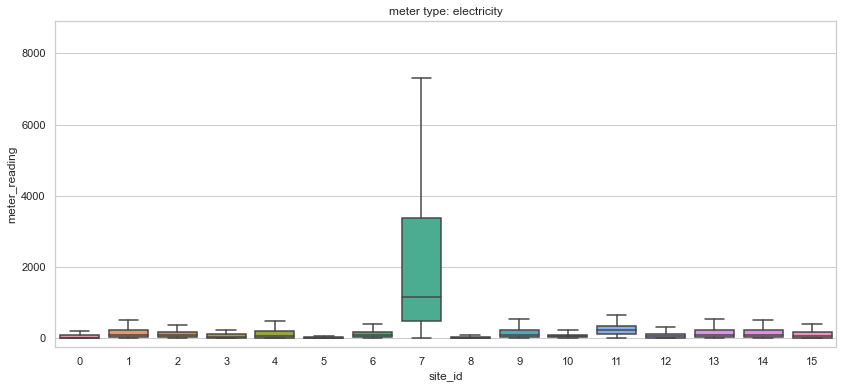

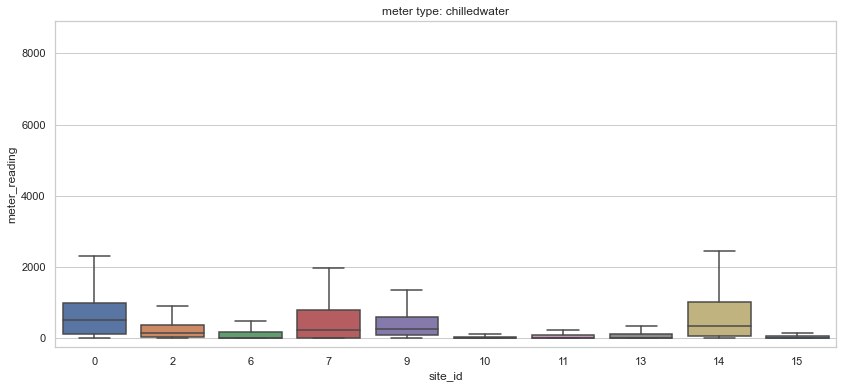

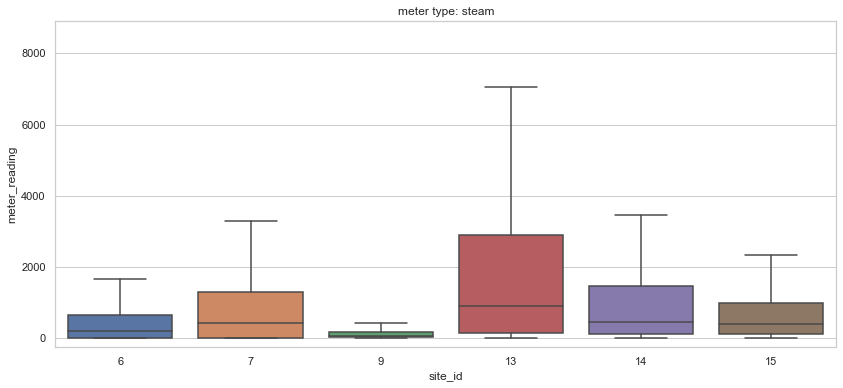

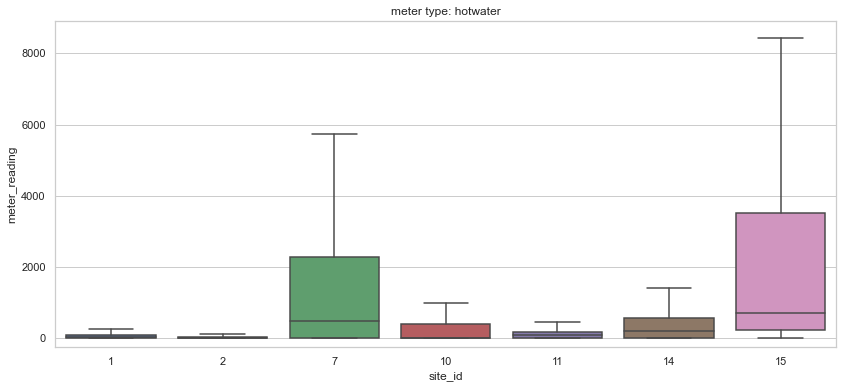

In [31]:
%%time
for i in [0, 1, 2, 3]:
    fig, axes = plt.subplots(1, 1, figsize=(14, 6))
    axes.set_ylim(-250, 8900)
    sns.boxplot(x='site_id', y='meter_reading', data=train[train.meter==i], showfliers=False)
    meter = meter_dict[i]
    plt.title(f'meter type: {meter}')

- While all sites have electricity reading, not every site has has other types of meter readings. 
- Steam and hot water in a couple of sites use a lot of energy than other meter types.
- Site 7 consumes high energy in each meter type than most other sites.

## Primary_use

In [32]:
print(f'There are totally {train.primary_use.nunique()} primary use types.')
print('The list of primary_use is:')
list(train.primary_use.unique())

There are totally 16 primary use types.
The list of primary_use is:


['Education',
 'Lodging/residential',
 'Office',
 'Entertainment/public assembly',
 'Other',
 'Retail',
 'Parking',
 'Public services',
 'Warehouse/storage',
 'Food sales and service',
 'Religious worship',
 'Healthcare',
 'Utility',
 'Technology/science',
 'Manufacturing/industrial',
 'Services']

Text(0.5, 1.0, 'Total consumption/year/primary_use')

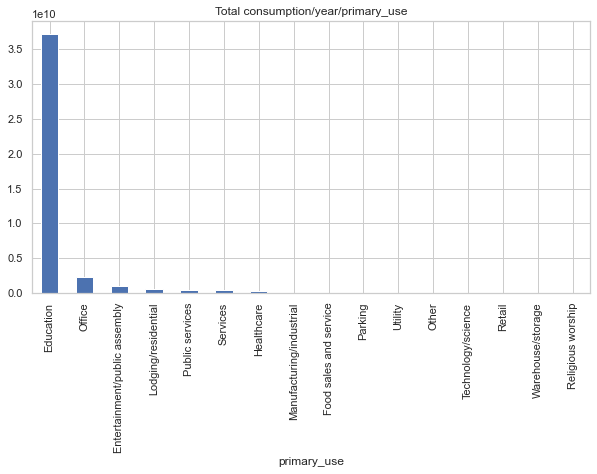

In [33]:
data = train.groupby('primary_use')['meter_reading'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
data.plot(kind='bar')
plt.title('Total consumption/year/primary_use')

- Education is predominant in energy consumpation.It is followed by office, entertainment/publis assembly, lodging/residential, etc.

### Look into primary_use's energy at 16 different sites

Text(0.5, 1.0, 'Year 2006 Total Consumption without Education')

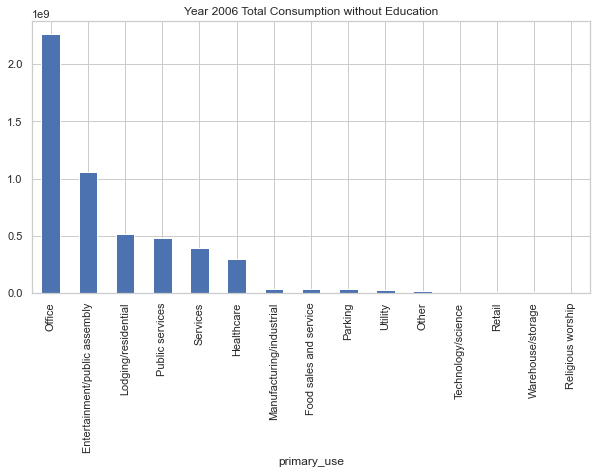

In [34]:
data = train.groupby('primary_use')['meter_reading'].sum().sort_values(ascending=False)
data.pop('Education')
plt.figure(figsize=(10,5))
data.plot(kind='bar')
plt.title('Year 2006 Total Consumption without Education')

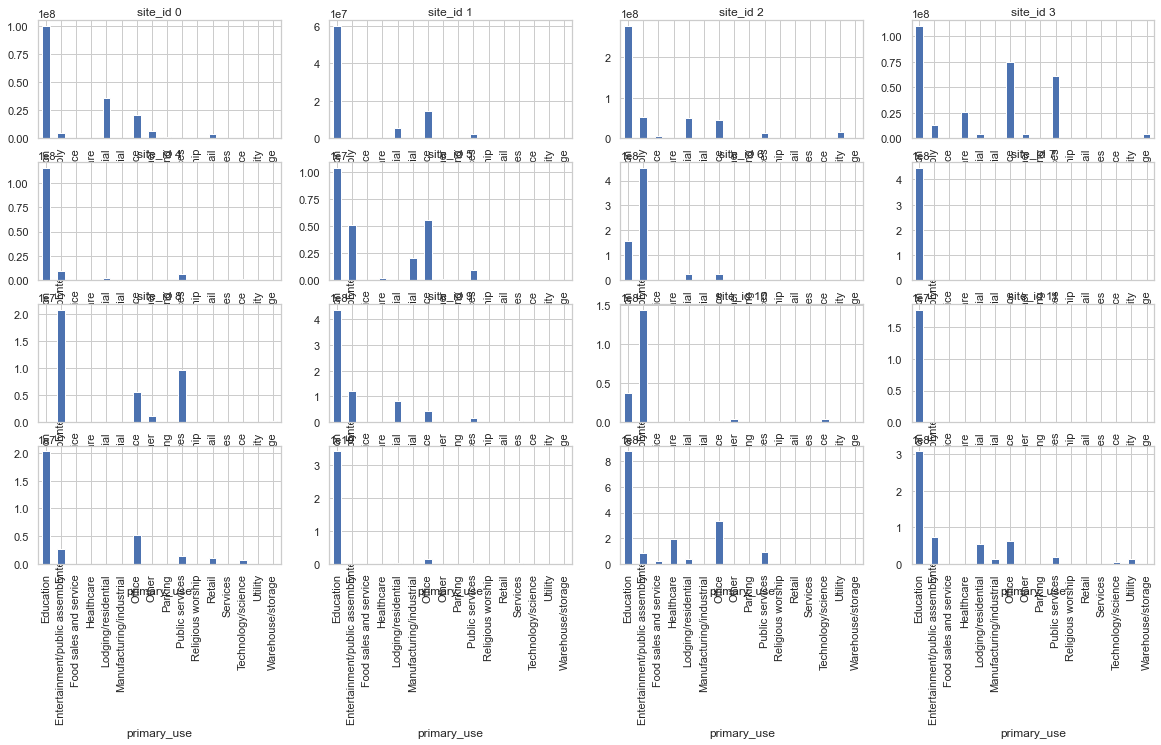

In [36]:
data = train.groupby(['site_id', 'primary_use'])['meter_reading'].sum().reset_index()
fig1, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 10), constrained_layout=False)
axs = trim_axs(axs, N = 16)
for axx, site_id in zip(axs, range(16)):
    # axx.set_ylabel('total energy')
    if site_id < 12:
        # plt.xticks(labels=None)
        # axx.xaxis.set_ticks_position('none') 
        # axx.set_xticklabels(labels=None)
        axx.set_title(f'site_id {site_id}')
        data[data.site_id==site_id].set_index('primary_use')['meter_reading'].plot(kind='bar', ax=axx, label=None)
    else:
        data[data.site_id==site_id].set_index('primary_use')['meter_reading'].plot(kind='bar', ax=axx)

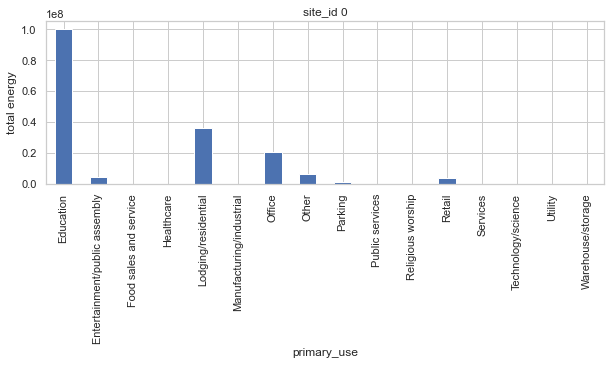

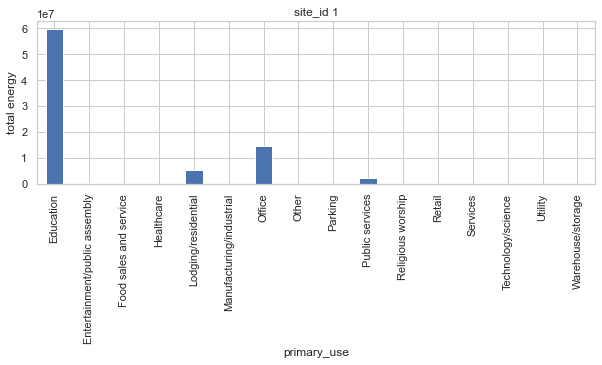

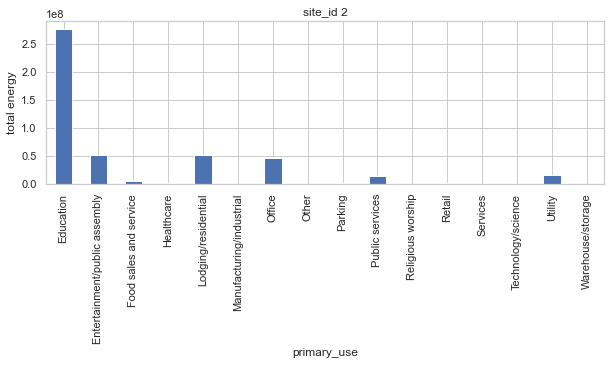

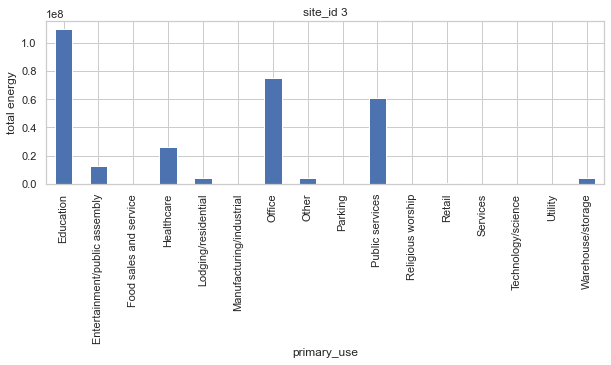

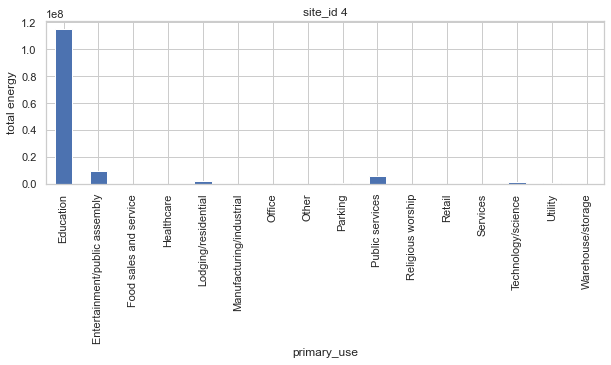

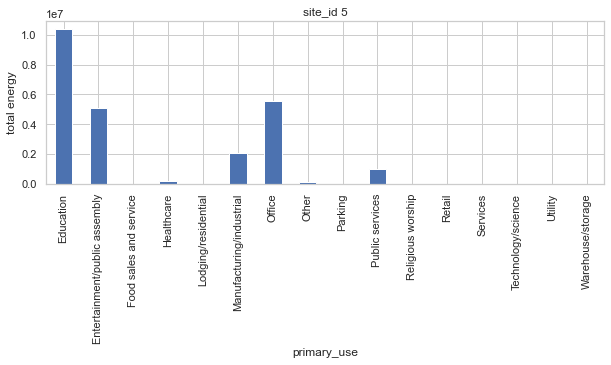

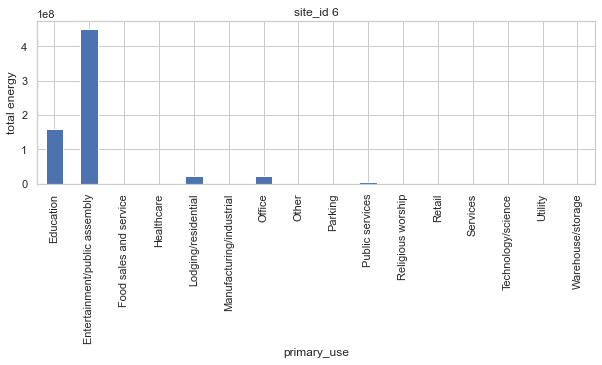

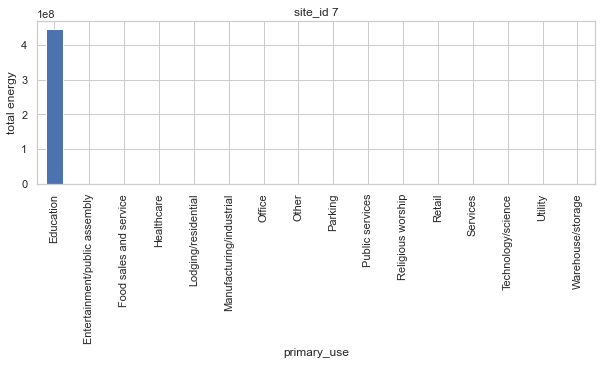

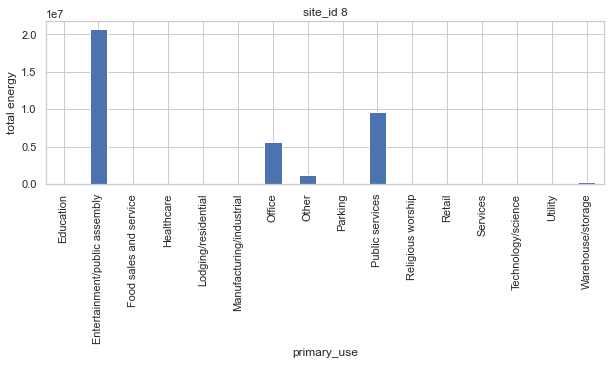

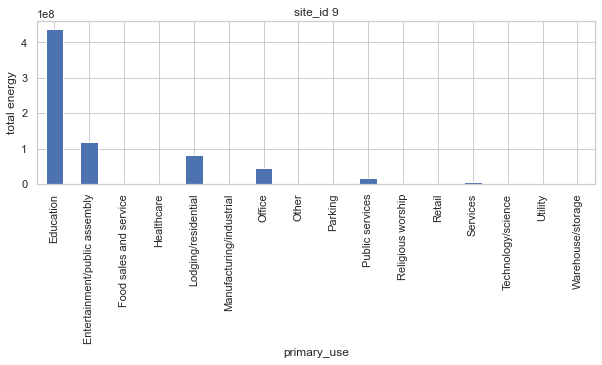

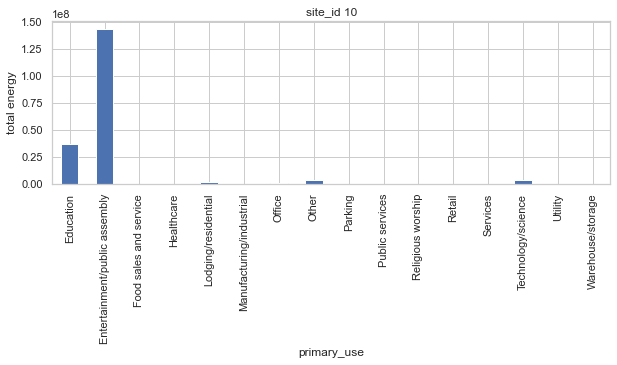

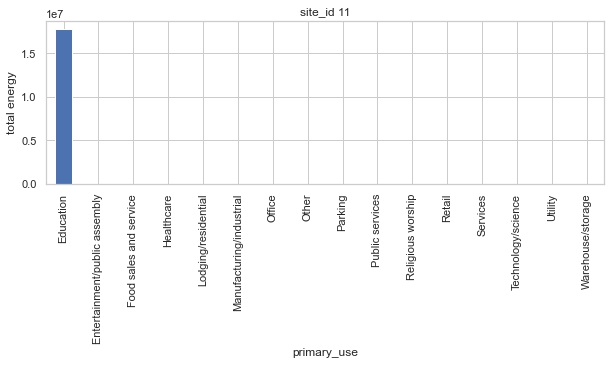

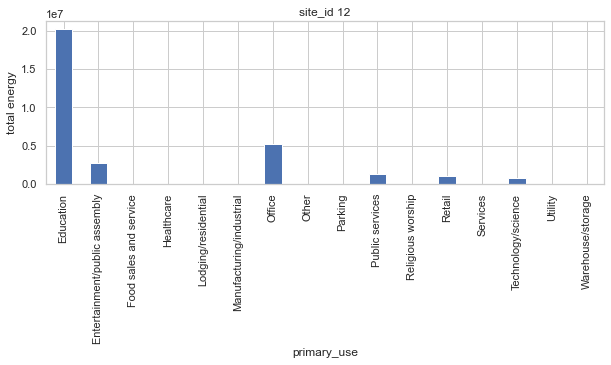

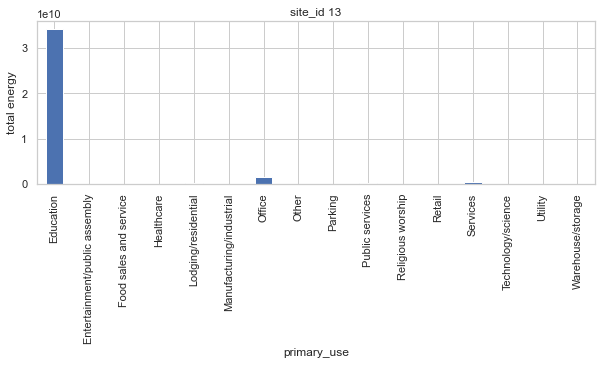

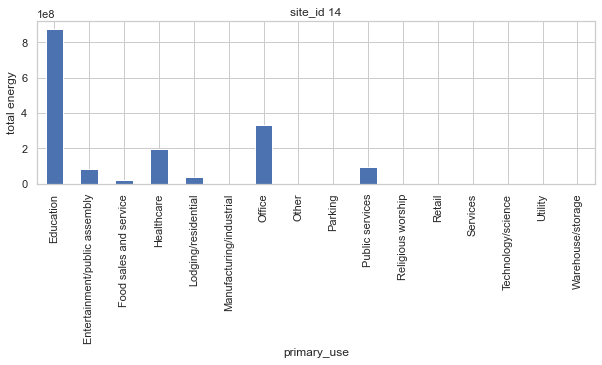

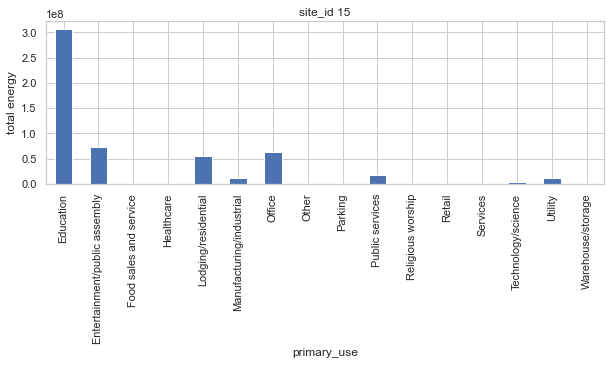

In [39]:
data = train.groupby(['site_id', 'primary_use'])['meter_reading'].sum().reset_index()
for i in range(16):
    plt.figure(figsize=(10,3))
    data[data.site_id==i].set_index('primary_use')['meter_reading'].plot(kind='bar')
    plt.ylabel('total energy')
    plt.title(f'site_id {i}')

- In most sites, Education takes major energy consumption share except for site 6, 8, 10 in which Entertainment/public assebly is predominant.

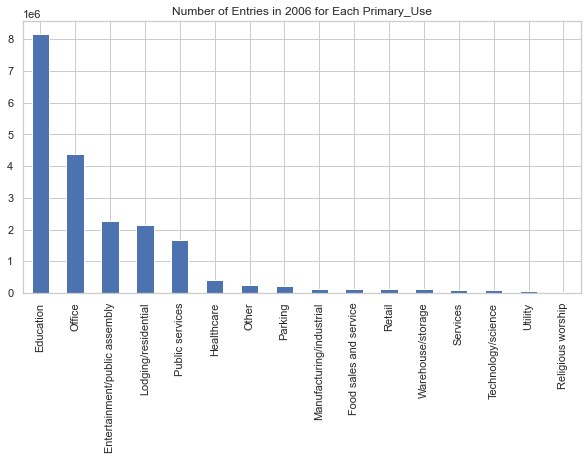

In [40]:
train.primary_use.value_counts().plot.bar(figsize=(10,5), color='b', title='Number of Entries in 2006 for Each Primary_Use')

- The number of total entries for Education is also far greater than other primary_use, explaining its high usage.

### primary_use's totoal energy over time

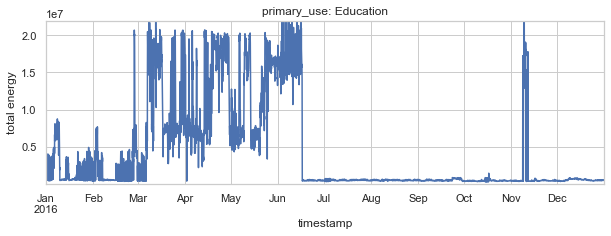

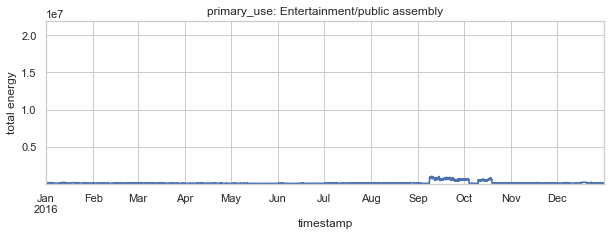

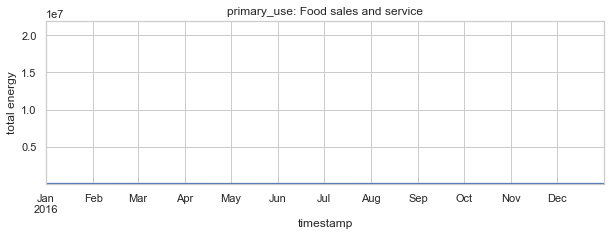

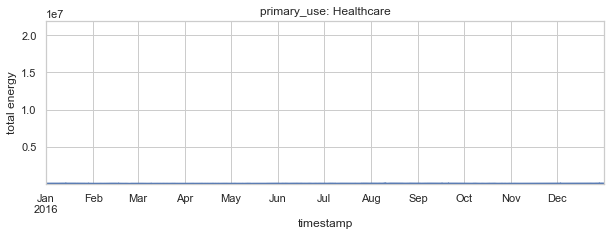

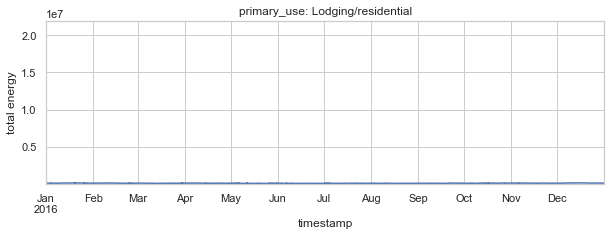

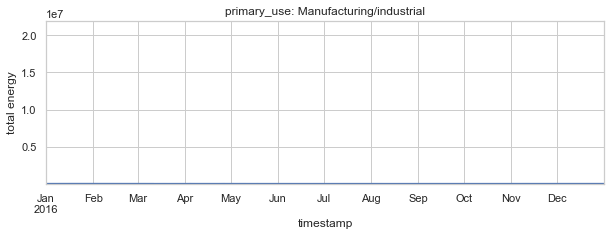

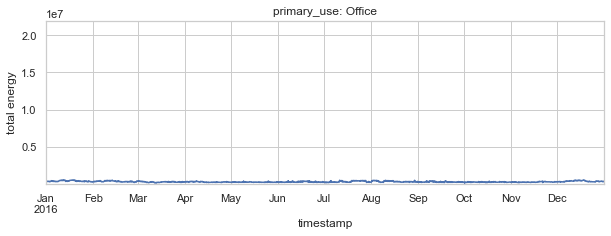

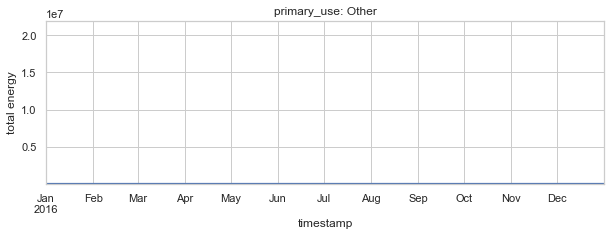

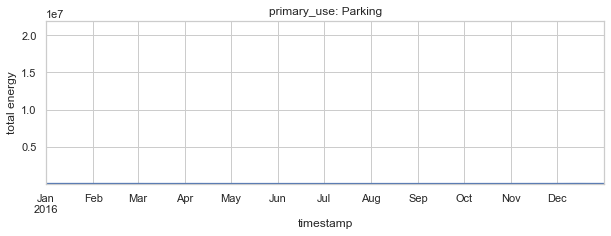

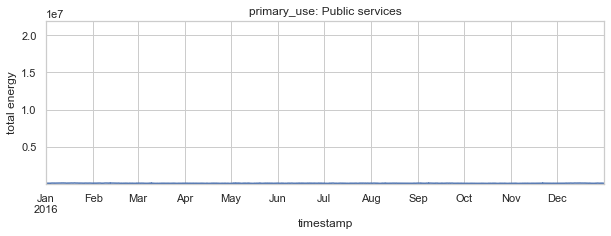

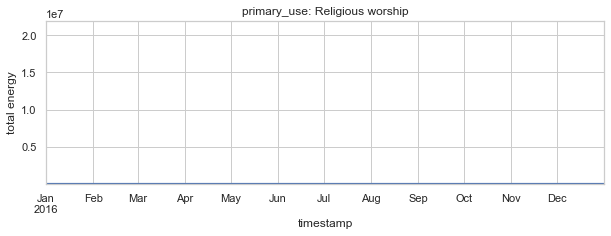

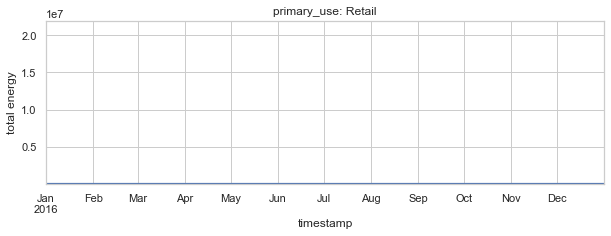

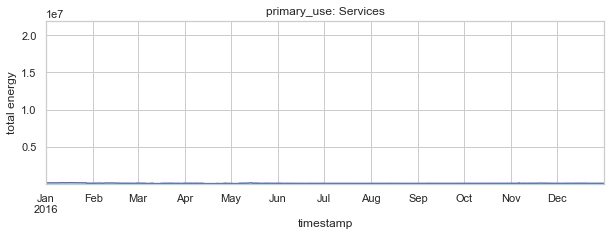

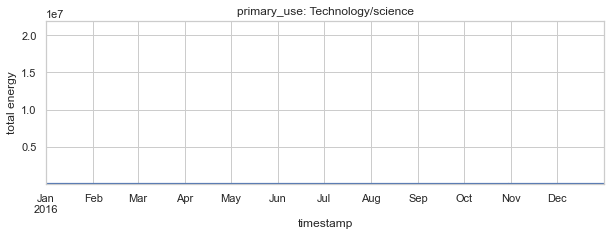

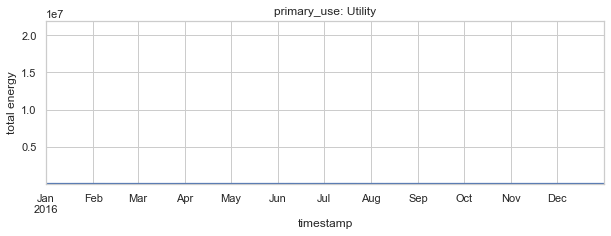

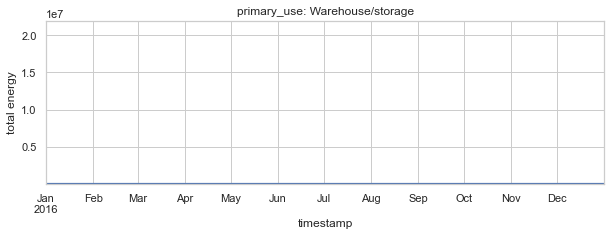

In [41]:
data = train.groupby(['timestamp', 'primary_use'])['meter_reading'].sum().reset_index()
for i in data.primary_use.unique():
    plt.figure(figsize=(10,3))
    data[data.primary_use==i].set_index('timestamp')['meter_reading'].plot()
    plt.ylim(0.1, 2.2e7)
    plt.ylabel('total energy')    
    plt.title(f'primary_use: {i}')

- Again, education is predominantly the largest customer over a year period.

### put together

In [42]:
groupby_pxline(train, 'date', 'primary_use', 'meter_reading')

# Weather

Wall time: 29.9 s


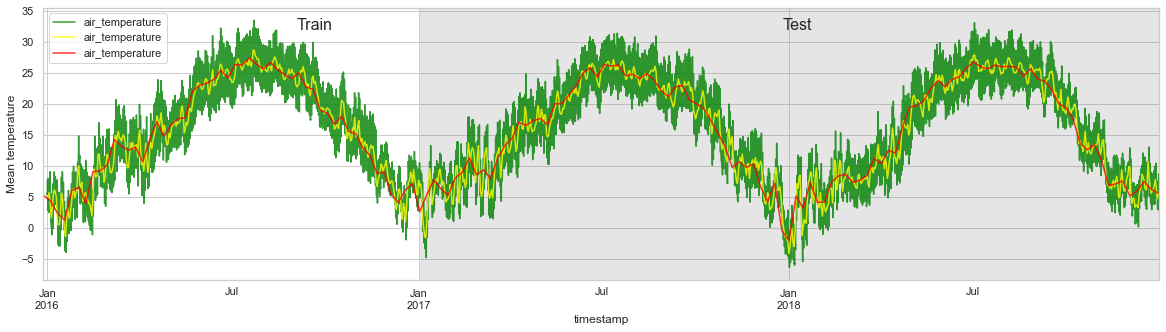

In [43]:
%%time
df = pd.concat([train[['timestamp', 'air_temperature']], test[['timestamp', 'air_temperature']]]).set_index('timestamp')
fig, axes = plt.subplots(1,1,figsize=(20, 5))
df.resample('H').mean().plot(ax=axes, alpha=0.8, label='By hour', color='green')
df.resample('D').mean().plot(ax=axes, alpha=0.8, label='By day', color='yellow')
df.resample('W').mean().plot(ax=axes, alpha=0.8, label='By week', color='red')
axes.set_ylabel('Mean temperature')
axes.legend()
axes.text(train['timestamp'].iloc[13477400], 32, 'Train', fontsize=16)
axes.text(test['timestamp'].iloc[29400000], 32, 'Test', fontsize=16)
axes.axvspan(test['timestamp'].min(), test['timestamp'].max(), facecolor='grey', alpha=0.2)

- Air temperatue in the test set has very similar pattern as in the train set or previous year.

# Missing Values

In [44]:
data = (1 -(train.count() / len(train))).sort_values()
data = pd.DataFrame(data, columns=['Missing Percentage'])
data

,Missing Percentage
building_id,0.000000
primary_use_encoded,0.000000
square_feet,0.000000
primary_use,0.000000
date,0.000000
meter_reading,0.000000
timestamp,0.000000
meter,0.000000
site_id,0.000000
air_temperature,0.004781


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text major ticklabel objects>)

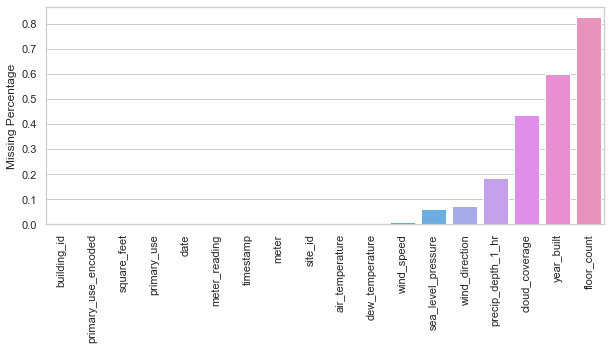

In [45]:
plt.figure(figsize=(10, 4))
sns.barplot(x=data.index, y="Missing Percentage", data=data)
plt.xticks(rotation=90)

- Top ranking in missing values: floor_count, year_built, cloud_coverage with more than 40% missing.

In [46]:
"""%%time
temp = train.drop('timestamp', axis=1)
plt.figure(figsize=(15,7))
sns.heatmap(temp.isnull(), cbar=False)
plt.savefig('missing.png')
plt.show()
del temp
# Wall time: 9min 31s"""

"%%time\ntemp = train.drop('timestamp', axis=1)\nplt.figure(figsize=(15,7))\nsns.heatmap(temp.isnull(), cbar=False)\nplt.savefig('missing.png')\nplt.show()\ndel temp\n# Wall time: 9min 31s"

- Y axis is time sequence for a whole year 2006.
- Missing values are kind of uniformly distributed along time. The missing data does not happen heavily in certain months. 

# Corretions of variables / features

In [47]:
# compute pairwise correlation of columns, excluding NA/null values.
corrs = train[num_cols].corr()
corrs

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,wind_speed
building_id,1.000000,0.222268,0.008997,0.980975,0.087704,-0.246150,-0.348353,-0.314149,-0.203832,-0.110091,0.003683
meter,0.222268,1.000000,0.017673,0.253875,0.132708,-0.003798,0.176926,-0.011159,-0.177186,-0.080445,-0.081169
meter_reading,0.008997,0.017673,1.000000,0.012108,0.024303,0.048569,0.130224,-0.004248,0.005936,-0.003489,0.006082
site_id,0.980975,0.253875,0.012108,1.000000,0.090934,-0.212378,-0.336626,-0.307199,-0.179160,-0.135186,0.011564
square_feet,0.087704,0.132708,0.024303,0.090934,1.000000,0.135717,0.584495,-0.015665,-0.041162,-0.023385,-0.034896
year_built,-0.246150,-0.003798,0.048569,-0.212378,0.135717,1.000000,0.147381,0.174156,0.062713,0.117523,-0.044890
floor_count,-0.348353,0.176926,0.130224,-0.336626,0.584495,0.147381,1.000000,-0.183969,-0.106147,-0.174681,-0.020451
air_temperature,-0.314149,-0.011159,-0.004248,-0.307199,-0.015665,0.174156,-0.183969,1.000000,0.045196,0.750640,-0.081765
cloud_coverage,-0.203832,-0.177186,0.005936,-0.179160,-0.041162,0.062713,-0.106147,0.045196,1.000000,0.132972,0.244121
dew_temperature,-0.110091,-0.080445,-0.003489,-0.135186,-0.023385,0.117523,-0.174681,0.750640,0.132972,1.000000,-0.141874


In [48]:
num_cols

['building_id',
 'meter',
 'meter_reading',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'wind_speed']

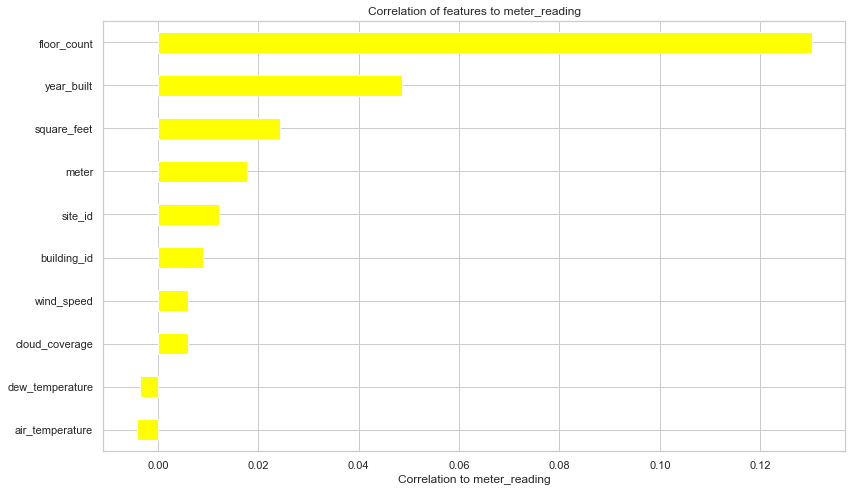

In [49]:
plt.figure(figsize=(12,7))
corrs["meter_reading"].sort_values(ascending=True)[:-1].plot(kind="barh", color='yellow')
plt.title("Correlation of features to meter_reading")
plt.xlabel("Correlation to meter_reading")
plt.tight_layout()
plt.show()

Wall time: 13.4 s


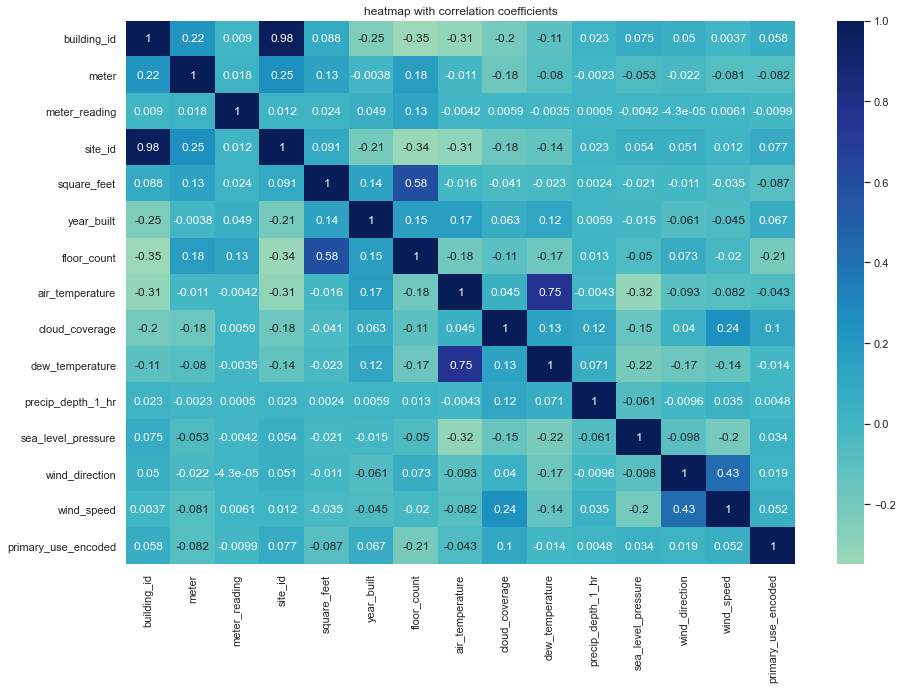

In [50]:
%%time
temp = train.drop(['timestamp', 'primary_use'], axis=1)
corrs = temp.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corrs, annot=True, cmap="YlGnBu", center=0)
plt.title('heatmap with correlation coefficients')

- site_id correlated to building_id very well, which should be.
- floor_count and square_feet are also related to each other.
- The correlation  coefficient between dew_temperature and air_temperature is 0.75, which agrees well with meteorology study.

# Outlier analysis